# Resolved Vector Velocities - "New" Version

This tutorial covers how to read in, plot, and work with the new output vector velocities data product.

```{admonition} WIP
This page is currently a **work in progress**, meaning it likely has incomplete explanations and some non-functional code/links/ect.  Please be patient!

If you think you can help, please consider [contributing](https://github.com/ljlamarche/amisr_user_manual#contributing-material).
```



In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import re
import h5py
import numpy as np
from apexpy import Apex
import pymap3d as pm
import cartopy.crs as ccrs

## Background

The resolved vector velocity data product (informally known as "vvels") is derived from the standard AMISR processed parameters.  By assuming some degree of uniform flow across the FoV, it is possible to combine LoS velocity measurements from different beams to invert a full 3D velocity vector.  This technique is described in detail in {cite}`Heinselman2008`.

### Magnetic Field Mapping

The resolved velocities algorithms assumes the plasma drift velocity maps along the magnetic field lines and is only valid in the regime where this holds true.  Under the electrostatic assumption (no parallel electric fields), the electric potential is constant along magnetic field lines and an electric field can be mapped to anywhere on that field line.  In the collisionless regime, the plasma velocity is the $E \times B$ drift velocity and likewise maps along field lines.  This allows the resolved velocities to utilize LoS measurements from all F-region altitudes.

### Apex Coordinates

The resolved velocities inversion algorithm could be implemented in any magnetic coordinate system. We choose to use the Modified Apex coordinate system {cite}`Richmond1995,Laundal2017` for the following reasons:

- It is defined everywhere on the globe
- Apex base vectors are scaled in such a way that mapping the electric field and plasma drift velocity in the near-Earth environment is very convenient
- There is computationally efficient python package, [apexpy](https://apexpy.readthedocs.io/en/latest/index.html), for coordinate conversions that includes covariant and contravariant base vectors (nessicary for vector calculations)

The apex covariant, $\mathbf{e}_i$, and contravariant, $\mathbf{d}_i$, base vectors are oriented such that $\mathbf{e}_3$ and $\mathbf{d}_3$ are in the direction of the magnetic field, $\mathbf{e}_1$ and $\mathbf{d}_1$ are roughly eastwards, and $\mathbf{e}_2$ and $\mathbf{d}_2$ complete the right-handed coordinate system (roughly southwards in the Northern Hemisphere at high latitudes).  The $\mathbf{e}_1$, $\mathbf{e}_2$, $\mathbf{d}_1$ and $\mathbf{d}_1$ base vectors are all perpendicular to the magnetic field.

Base vectors are scaled such that the covariant components of the plasma drift velocity ($V_{e_1}$ and $V_{e_2}$) and the corresponding contravarient components of the electric field ($E_{d_1}$ and $E_{d_2}$) are constant at all altitudes along a magnetic field line.  


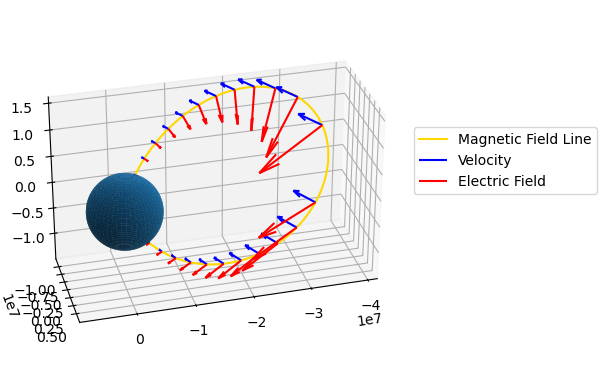

In [2]:
A = Apex(2023)
glat = 65.7
glon = -147.7
mlat, mlon = A.geo2apex(glat, glon, 300.)

# Create field line array
apex_height = A.get_apex(mlat)
galt = np.arange(0., apex_height, 100.)*1000.
glatN, glonN, _ = A.map_to_height(glat, glon, 300., galt/1000.)
glatS, glonS, _ = A.map_to_height(glat, glon, 300., galt/1000., conjugate=True)
# Combine north and south mapped arrays
fl_glat = np.concatenate((glatN,glatS[::-1]))
fl_glon = np.concatenate((glonN,glonS[::-1]))
fl_galt = np.concatenate((galt,galt[::-1]))

f1, f2, f3, g1, g2, g3, d1, d2, d3, e1, e2, e3 = A.basevectors_apex(glat, glon, 300.)
efield = 500.*d2
vel = 500.*e1
# Subsample field line array to get locations for vectors
vec_galt = fl_galt[::30]
vec_glat = fl_glat[::30]
vec_glon = fl_glon[::30]
# Map vectors to these locations
mapped_vel = A.map_V_to_height(mlat, mlon, 300., vec_galt/1000., vel)
mapped_ef = A.map_V_to_height(mlat, mlon, 300., vec_galt/1000., efield)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 6371.*1000. * np.outer(np.cos(u), np.sin(v))
y = 6371.*1000. * np.outer(np.sin(u), np.sin(v))
z = 6371.*1000. * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z)

# Plot field line
x, y, z = pm.geodetic2ecef(fl_glat, fl_glon, fl_galt)
ax.plot(x, y, z, color='gold', label='Magnetic Field Line')

# Plot velocity/electric field
x, y, z = pm.geodetic2ecef(vec_glat, vec_glon, vec_galt)
u, v, w = pm.enu2uvw(mapped_vel[0,:], mapped_vel[1,:], mapped_vel[2,:], vec_glat, vec_glon)
ax.quiver(x, y, z, u, v, w, length=1000., color='blue', label='Velocity')
u, v, w = pm.enu2uvw(mapped_ef[0,:], mapped_ef[1,:], mapped_ef[2,:], vec_glat, vec_glon)
ax.quiver(x, y, z, u, v, w, length=1000., color='red', label='Electric Field')

ax.legend(loc=(1.05, 0.5))

ax.view_init(azim=75.)
# Set an equal aspect ratio
ax.set_aspect('equal')


### Binning

Instead of calculating a single vector velocity over the entire AMISR FoV, the FoV is usually broken into several bins based on magnetic latitude and the velocity is assumed constant in each bin.  This works relatively well as auroral structures tend to be oriented along magnetic parallels and it allows us to resolve some variation in the flow structure in magnetic latitude.  These bins are customizable when the resolved vector velocities code is run and do not need to cover the entire longitudinal range of the FoV, but it is recommended they do to maximize the diversity of look-angles used and make the inversion more well-poised.

## Resolved Vector Velocity Data

The velocity vector inversion is done in magnetic coordinates, but for convenience, output files contain the resulting vector in both geodetic and magnetic coordinates.  These are stored in the `VvelsGeoCoords` and the `VvelsMagCoords` groups respectively.  The `ProcessingParams`, `Site`, and `Time` groups are similar to those in the original processed data files.


In [3]:
filepath='../data/20200207.001_lp_5min-fitcal-vvels_lat.h5'

In [4]:
with h5py.File(filepath, 'r') as h5:
    for k in h5.keys():
        print(k)

ProcessingParams
Site
Time
VvelsGeoCoords
VvelsMagCoords


### Magnetic Components

The magnetic components of the velocity vector is the native output of the resolved velocities inversion algorithm.  All other output parameters in the file are derived from these.

The plasma drift velocity components $V_{e_1}$, $V_{e_2}$, and $V_{e_3}$ are available in the `VvelsMagCoords` group in the variable `Velocity`.  This array has the dimensions nrecords x nbins x 3.

Because the inversion algorithm assumes the velocity is purely the $E \times B$ plasma drift velocity that is perpendicular to the magnetic fields, the $V_{e_3}$ component SHOULD be zero. This is often not the case in the output, but it is typically orders of magnitude less than the perp-B components and can be thought of as a residual to the fit.


Text(0.5, 0, 'Universal Time')

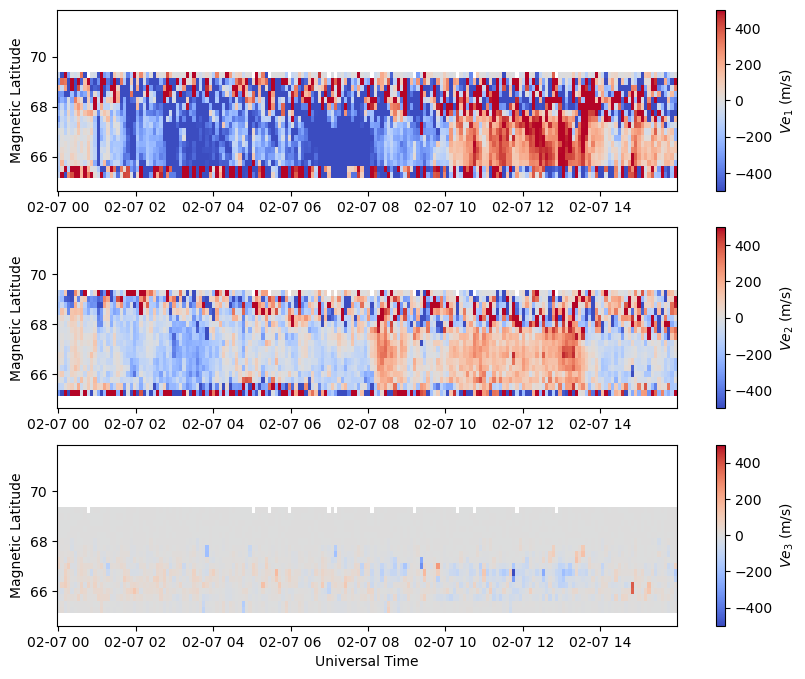

In [5]:
with h5py.File(filepath, 'r') as h5:
    mlat = h5['VvelsMagCoords/Latitude'][:]
    vel = h5['VvelsMagCoords/Velocity'][:]
    utime = h5['Time/UnixTime'][:,0]

time = utime.astype('datetime64[s]')

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3,1)
ax = [fig.add_subplot(gs[i]) for i in range(3)]
for i in range(3):
    c = ax[i].pcolormesh(time, mlat, vel[:,:,i].T, vmin=-500., vmax=500., cmap='coolwarm')
    ax[i].set_ylabel('Magnetic Latitude')
    fig.colorbar(c, label=fr'$Ve_{i+1}$ (m/s)')

ax[2].set_xlabel('Universal Time')


### Geodetic Components

The Geodetic East, North, and Up components of the vector velocities are available in the `VvelsGeoCoords` group in the variable `Velocity`.  The shape of this array is nrecords x nalt x nbins x 3, where the last dimension is for each of the three E, N, U components respectively.  Unlike the magnetic components, the geodetic components DO change in altitude, hence the additional altitude dimension in this array.  The values of these altitude slices are in `Altitude`.

Text(0.5, 0, 'Universal Time')

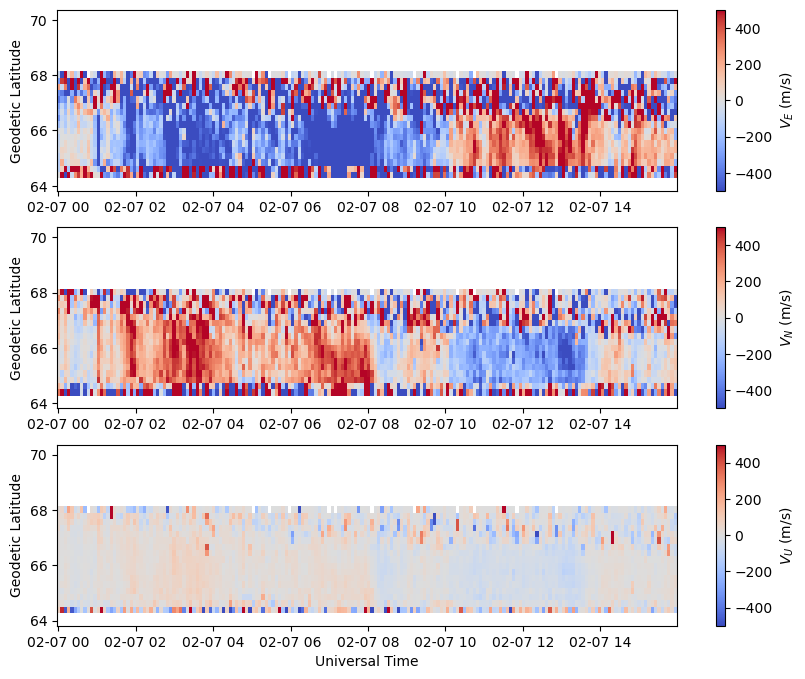

In [6]:
targalt = 300.

with h5py.File(filepath, 'r') as h5:
    alt = h5['VvelsGeoCoords/Altitude'][:,0]
    aidx = np.argmin(np.abs(alt-targalt))
    glat = h5['VvelsGeoCoords/Latitude'][aidx,:]
    vel = h5['VvelsGeoCoords/Velocity'][:,aidx,:,:]
    utime = h5['Time/UnixTime'][:,0]

time = utime.astype('datetime64[s]')

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3,1)
ax = [fig.add_subplot(gs[i]) for i in range(3)]
for i, comp in enumerate(['E','N','U']):
    c = ax[i].pcolormesh(time, glat, vel[:,:,i].T, vmin=-500., vmax=500., cmap='coolwarm')
    ax[i].set_ylabel('Geodetic Latitude')
    fig.colorbar(c, label=fr'$V_{comp}$ (m/s)')

ax[2].set_xlabel('Universal Time')


### Magnitude and Direction

The magnitude and horizontal direction (azimuth angle in degrees East of North) of the resolved velocity vectors are also available in the `VvelsGeoCoords` group as `Vmag` and `Vdir`, respectively.  These are scalar quantities but also depend on altitude, so have the dimensions nrecords x nalt x nbins.

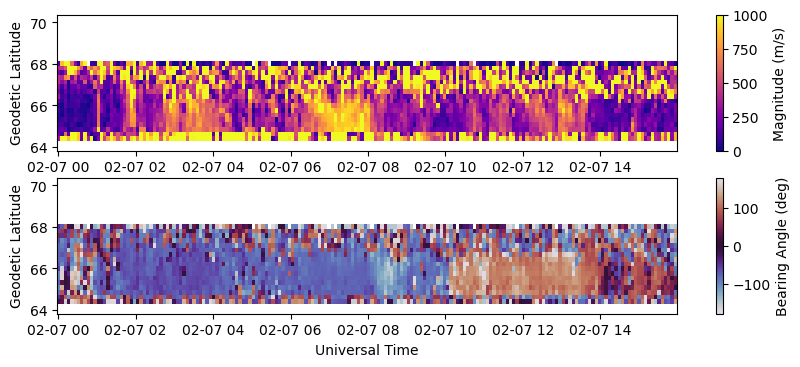

In [25]:
targalt = 300.

with h5py.File(filepath, 'r') as h5:
    alt = h5['VvelsGeoCoords/Altitude'][:,0]
    aidx = np.argmin(np.abs(alt-targalt))
    glat = h5['VvelsGeoCoords/Latitude'][aidx,:]
    vmag = h5['VvelsGeoCoords/Vmag'][:,aidx,:]
    vdir = h5['VvelsGeoCoords/Vdir'][:,aidx,:]
    utime = h5['Time/UnixTime'][:,0]

time = utime.astype('datetime64[s]')

fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(3,1)
ax = fig.add_subplot(gs[0])
c = ax.pcolormesh(time, glat, vmag.T, vmin=0., vmax=1000., cmap='plasma')
ax.set_ylabel('Geodetic Latitude')
fig.colorbar(c, label='Magnitude (m/s)')

ax = fig.add_subplot(gs[1])
c = ax.pcolormesh(time, glat, vdir.T, vmin=-180., vmax=180., cmap='twilight')
ax.set_xlabel('Universal Time')
ax.set_ylabel('Geodetic Latitude')
fig.colorbar(c, label='Bearing Angle (deg)')


## Electric Field

The electric field is calculated from the vector velocity, assuming only $E \times B$ plasma drift.

$$ \mathbf{E} = - \mathbf{V} \times \mathbf{B} $$

The electric field and velocity in the resolved velocities files are not independent measurements.  Both are provided for user convenience.  By definition, there is no parallel electric field component ($E_{d_3} = 0 $).

Similar to velocity, the output files contain the electric field in both geodetic and magnetic coordinates stored in the `VvelsGeoCoords` and the `VvelsMagCoords` groups respectively.


### Magnetic Components

The electric field components $E_{d_1}$, $E_{d_2}$, and $E_{d_3}$ are available in the `VvelsMagCoords` group in the variable `Electric Field`.  This array has the dimensions nrecords x nbins x 3.


Text(0.5, 0, 'Universal Time')

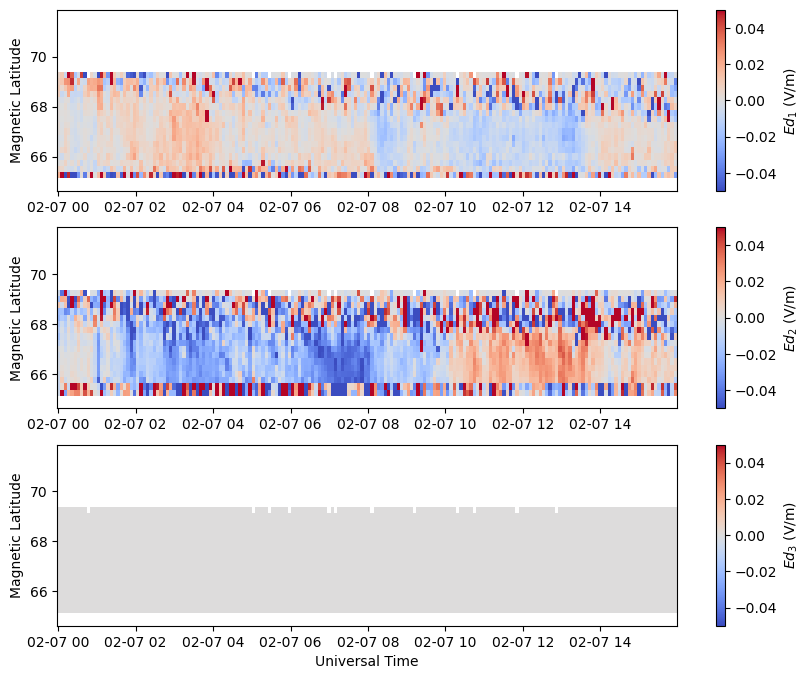

In [7]:
with h5py.File(filepath, 'r') as h5:
    mlat = h5['VvelsMagCoords/Latitude'][:]
    efield = h5['VvelsMagCoords/ElectricField'][:]
    utime = h5['Time/UnixTime'][:,0]

time = utime.astype('datetime64[s]')

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3,1)
ax = [fig.add_subplot(gs[i]) for i in range(3)]
for i in range(3):
    c = ax[i].pcolormesh(time, mlat, efield[:,:,i].T, vmin=-0.05, vmax=0.05, cmap='coolwarm')
    ax[i].set_ylabel('Magnetic Latitude')
    fig.colorbar(c, label=fr'$Ed_{i+1}$ (V/m)')

ax[2].set_xlabel('Universal Time')


### Geodetic Components

The Geodetic East, North, and Up components of the electric field are available in the `VvelsGeoCoords` group in the variable `ElectricField`.  The shape of this array is nrecords x nalt x nbins x 3, where the last dimension is for each of the three E, N, U components respectively.  Similar to the velocity, the additional altitude dimension captures the fact that the geodetic components change in altitude and the value of each altitude slice can be found in `Altitude`.

Text(0.5, 0, 'Universal Time')

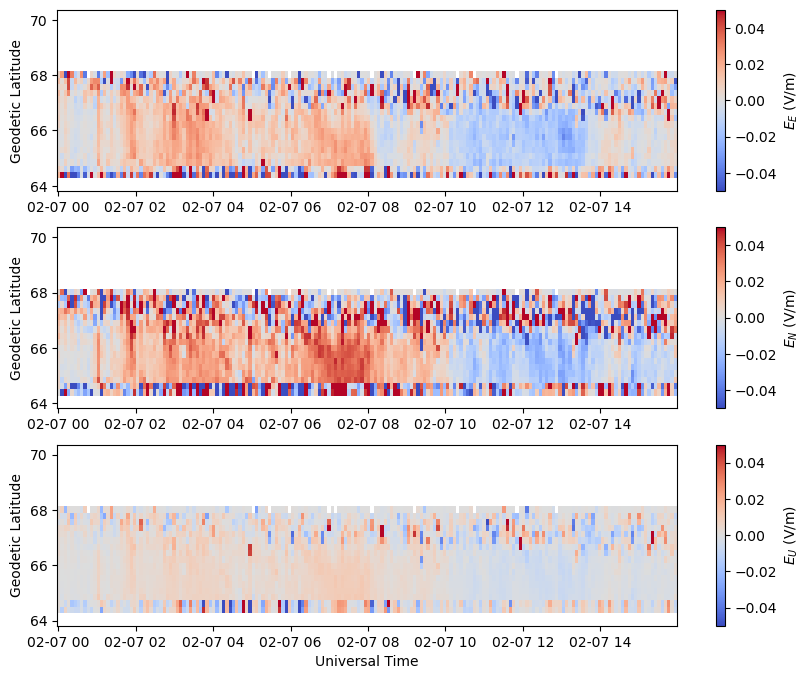

In [8]:
targalt = 300.

with h5py.File(filepath, 'r') as h5:
    alt = h5['VvelsGeoCoords/Altitude'][:,0]
    aidx = np.argmin(np.abs(alt-targalt))
    glat = h5['VvelsGeoCoords/Latitude'][aidx,:]
    efield = h5['VvelsGeoCoords/ElectricField'][:,aidx,:,:]
    utime = h5['Time/UnixTime'][:,0]

time = utime.astype('datetime64[s]')

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3,1)
ax = [fig.add_subplot(gs[i]) for i in range(3)]
for i, comp in enumerate(['E','N','U']):
    c = ax[i].pcolormesh(time, glat, efield[:,:,i].T, vmin=-0.05, vmax=0.05, cmap='coolwarm')
    ax[i].set_ylabel('Geodetic Latitude')
    fig.colorbar(c, label=fr'$E_{comp}$ (V/m)')

ax[2].set_xlabel('Universal Time')


### Magnitude and Direction

The magnitude and horizontal direction (azimuth angle in degrees East of North) of the electric field are also available in the `VvelsGeoCoords` group as `Emag` and `Edir`, respectively.  These are scalar quantities but also depend on altitude, so have the dimensions nrecords x nalt x nbins.

<KeysViewHDF5 ['Altitude', 'CovarianceE', 'CovarianceV', 'Edir', 'ElectricField', 'Emag', 'Latitude', 'Longitude', 'Vdir', 'Velocity', 'Vmag', 'errEdir', 'errElectricField', 'errEmag', 'errVdir', 'errVelocity', 'errVmag']>


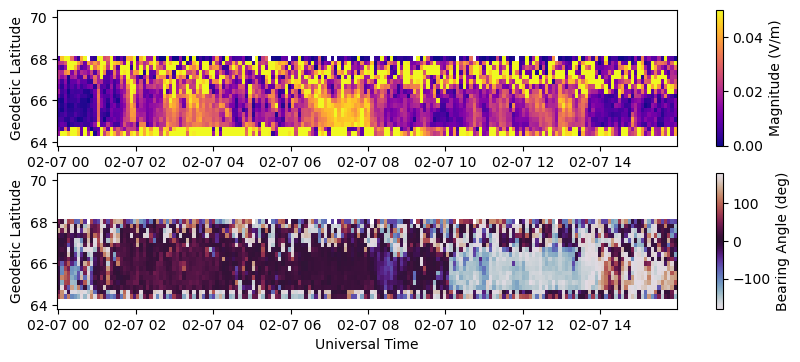

In [9]:
targalt = 300.

with h5py.File(filepath, 'r') as h5:
    print(h5['VvelsGeoCoords'].keys())
    alt = h5['VvelsGeoCoords/Altitude'][:,0]
    aidx = np.argmin(np.abs(alt-targalt))
    glat = h5['VvelsGeoCoords/Latitude'][aidx,:]
    emag = h5['VvelsGeoCoords/Emag'][:,aidx,:]
    edir = h5['VvelsGeoCoords/Edir'][:,aidx,:]
    utime = h5['Time/UnixTime'][:,0]

time = utime.astype('datetime64[s]')

fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(3,1)
ax = fig.add_subplot(gs[0])
c = ax.pcolormesh(time, glat, emag.T, vmin=0., vmax=0.05, cmap='plasma')
ax.set_ylabel('Geodetic Latitude')
fig.colorbar(c, label='Magnitude (V/m)')

ax = fig.add_subplot(gs[1])
c = ax.pcolormesh(time, glat, edir.T, vmin=-180., vmax=180., cmap='twilight')
ax.set_xlabel('Universal Time')
ax.set_ylabel('Geodetic Latitude')
fig.colorbar(c, label='Bearing Angle (deg)')


## Convert Magnetic to Geodetic

To convert magnetic vector components to geodetic vector components, use apexpy to find the base vectors for that location.  Then use Laundal and Richmond, 2017 eqn 75/77 to calculate the geodetic components of the vector.

$$ \mathbf{V} = V_{e_1} \mathbf{e}_1 + V_{e_2} \mathbf{e}_2 $$

$$ \mathbf{E} = E_{d_1} \mathbf{d}_1 + E_{d_2} \mathbf{d}_2 $$

When converting arrays of velocity vectors, it can be helpful to use Einstein notation with [numpy.einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

$$ V_{mnik}' = V_{mnij}e_{ijk} $$

For most use cases, geodetic components can be found in the `VvelsGeoCoords`, where they have been pre-calculated at set altitudes for user convenience.  Users should only have to manually convert from apex components to geodetic when velocity at a very specific altitude is needed, or other unusual circumstances.

In [36]:
with h5py.File(filepath, 'r') as h5:
    print(h5['VvelsMagCoords'].keys())
    mlat = h5['VvelsMagCoords/Latitude'][:]
    mlon = h5['VvelsMagCoords/Longitude'][:]
    vel = h5['VvelsMagCoords/Velocity'][:]
    efield = h5['VvelsMagCoords/ElectricField'][:]

A = Apex(2020)

# Convert a single point with a target altitude of 300 km
targalt = 300.
tidx = 10
bidx = 5
f1, f2, f3, g1, g2, g3, d1, d2, d3, e1, e2, e3 = A.basevectors_apex(mlat[bidx], mlon[bidx], targalt, coords='apex')
Ve1, Ve2, Ve3 = vel[tidx,bidx,:]
Ed1, Ed2, Ed3 = efield[tidx,bidx,:]

Vgeo = Ve1*e1 + Ve2*e2
print(f'Geodetic Velocity Components: {Vgeo}')
Egeo = Ed1*d1 + Ed2*d2
print(f'Geodetic Electric Field Components: {Egeo}')

# Convert full array
f1, f2, f3, g1, g2, g3, d1, d2, d3, e1, e2, e3 = A.basevectors_apex(mlat, mlon, 300., coords='apex')
e = np.array([e1, e2]).transpose((2,0,1))
d = np.array([d1, d2]).transpose((2,0,1))

Vgeo = np.einsum('...ij,ijk->...ik',vel[:,:,:2],e)
print(f'Original Velocity Shape: {vel.shape}')
print(f'Converted Velocity Shape: {Vgeo.shape}')

Egeo = np.einsum('...ij,ijk->...ik',efield[:,:,:2],d)
print(f'Original Electric Field Shape: {efield.shape}')
print(f'Converted Electric Field Shape: {Egeo.shape}')


<KeysViewHDF5 ['CovarianceE', 'CovarianceV', 'ElectricField', 'Latitude', 'Longitude', 'Velocity', 'errElectricField', 'errVelocity']>
Geodetic Velocity Components: [-55.96753607 -34.19414676 -11.09833093]
Geodetic Electric Field Components: [-0.00176155  0.00272533  0.0004865 ]
Original Velocity Shape: (188, 29, 3)
Converted Velocity Shape: (188, 29, 3)
Original Electric Field Shape: (188, 29, 3)
Converted Electric Field Shape: (188, 29, 3)


## Vector Errors

The resolved velocities files contain error arrays for the components (geodetic and magnetic), magnitudes, and directions.  The files also contain the full covariance matrices for the component arrays.  These are nessisary for error propogation when converting between different coordinate systems and other vector calculations.  The magnetic component covariance matrices have the shape nrecords x nbins x 3 x 3 while the geodetic component covariance matrices have the shape nrecords x nalt x nbins x 3 x 3.  The additional dimension in both cases represents the fact that the covariance matrix for a vector of length 3 has the shape 3 x 3.  To calculate the errors on individual components from a covariance matrix, take the square root of the diagonal components.

Plotting the error arrays reveals that the errors get extremely high in the northern-most and southern-most magnetic latitude bins where there are often few points in each bin to control the inversion.  This corresponds to the regions in the above plots that show a great deal of "salt and pepper" noise, and should generally not be trusted.

Velocity Shape: (188, 29, 3)
Velocity Error Shape: (188, 29, 3)
Velocity Covariance Shape: (188, 29, 3, 3)
Electric Field Shape: (188, 29, 3)
Electric Field Error Shape: (188, 29, 3)
Electric Field Covariance Shape: (188, 29, 3, 3)


Text(0.5, 0, 'Universal Time')

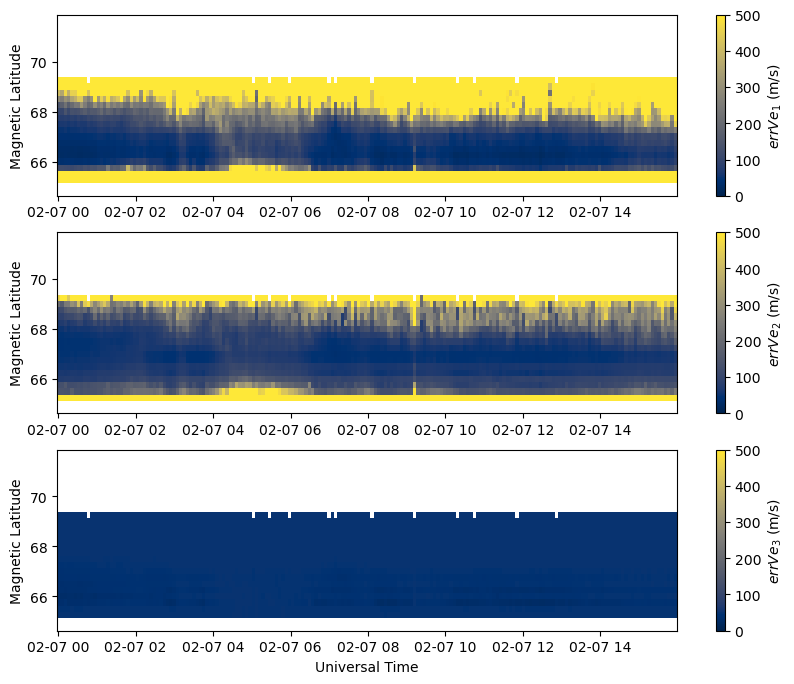

In [40]:
with h5py.File(filepath, 'r') as h5:
    mlat = h5['VvelsMagCoords/Latitude'][:]
    mlon = h5['VvelsMagCoords/Longitude'][:]
    vel = h5['VvelsMagCoords/Velocity'][:]
    errv = h5['VvelsMagCoords/errVelocity'][:]
    covv = h5['VvelsMagCoords/CovarianceV'][:]
    efield = h5['VvelsMagCoords/ElectricField'][:]
    erre = h5['VvelsMagCoords/errElectricField'][:]
    cove = h5['VvelsMagCoords/CovarianceE'][:]
    utime = h5['Time/UnixTime'][:,0]

time = utime.astype('datetime64[s]')

print(f'Velocity Shape: {vel.shape}')
print(f'Velocity Error Shape: {errv.shape}')
print(f'Velocity Covariance Shape: {covv.shape}')

print(f'Electric Field Shape: {efield.shape}')
print(f'Electric Field Error Shape: {erre.shape}')
print(f'Electric Field Covariance Shape: {cove.shape}')

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3,1)
ax = [fig.add_subplot(gs[i]) for i in range(3)]
for i in range(3):
    c = ax[i].pcolormesh(time, mlat, errv[:,:,i].T, vmin=0., vmax=500., cmap='cividis')
    ax[i].set_ylabel('Magnetic Latitude')
    fig.colorbar(c, label=fr'$err Ve_{i+1}$ (m/s)')

ax[2].set_xlabel('Universal Time')


## Plot Vectors on Map

To create a map of the velocity or electric field vectors on a map, load the geodetic components of the quantity of interest an plot them with quiver and cartopy.  Only the geodetic East and geodetic North components can be displayed this way.

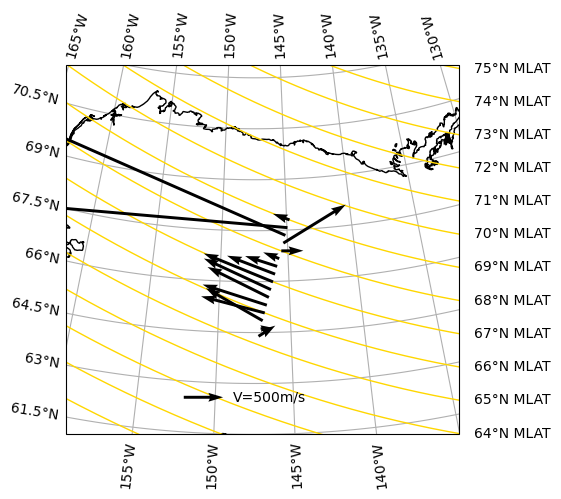

In [42]:
targalt = 300.
utargtime = np.datetime64('2020-02-07T07:00:00', '[s]').astype(int)

with h5py.File(filepath, 'r') as h5:

    site_lat = h5['Site/Latitude'][()]
    site_lon = h5['Site/Longitude'][()]
    alt = h5['VvelsGeoCoords/Altitude'][:,0]
    aidx = np.argmin(np.abs(alt-targalt))
    utime = h5['Time/UnixTime'][:,0]
    tidx = np.argmin(np.abs(utargtime-utime))
    glat = h5['VvelsGeoCoords/Latitude'][aidx,:]
    glon = h5['VvelsGeoCoords/Longitude'][aidx,:]
    vel = h5['VvelsGeoCoords/Velocity'][tidx,aidx,:,:]

time = utime.astype('datetime64[s]')

# generate figure
fig = plt.figure()

# create map
proj = ccrs.AzimuthalEquidistant(central_longitude=site_lon, central_latitude=site_lat)
ax = fig.add_subplot(111, projection=proj)
gl = ax.gridlines(draw_labels=True, zorder=1)
gl.right_labels = False
ax.coastlines()
ax.set_extent([-159., -135., 61., 72.], crs=ccrs.PlateCarree())

# This function is needed due to an issue with cartopy where vectors are not scale/rotated
#   correctly in some coordinate systems (see: https://github.com/SciTools/cartopy/issues/1179)
def scale_uv(lon, lat, u, v):
    us = u/np.cos(lat*np.pi/180.)
    vs = v
    sf = np.sqrt(u**2+v**2)/np.sqrt(us**2+vs**2)
    return us*sf, vs*sf

u, v = scale_uv(glon, glat, vel[:,0], vel[:,1])
Q = ax.quiver(glon, glat, u, v, zorder=5, scale=5000, linewidth=2, color='k', transform=ccrs.PlateCarree())

ax.quiverkey(Q, 0.4, 0.1, 500, 'V=500m/s', labelpos='E', transform=ax.transAxes)


# Add magnetic parallels for visualization convenience
mlon_arr = np.linspace(-150., -50., 100)
x0, x1, y0, y1 = ax.get_extent()

for mlat in np.arange(60., 76., 1.):
    mlat_arr = np.full(100, mlat)

    glat_arr, glon_arr, _ = A.apex2geo(mlat_arr, mlon_arr, height=targalt)
    line = proj.transform_points(ccrs.Geodetic(), glon_arr, glat_arr)
    ax.plot(line[:,0], line[:,1], linewidth=1., color='gold', zorder=2)

    yl = np.interp(x1, line[:,0], line[:,1])
    if yl>y0 and yl<y1:
        ax.text(x1+5e4, yl, f'{mlat:.0f}°N MLAT', verticalalignment='center')

